# **Image clustering on Caltech 101 dataset**

---

## **Contents**

- Importing dataset from Kaggle
- Building image data generator
- Loading model from Google Drive
- Extracting features from the model
- Implementing PCA
- Implementing K-Means Clustering
  - Viewing images in a cluster
- Conclusion

---

In [28]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

---

## **Importing dataset from kaggle**

The dataset is taken from kaggle (https://www.kaggle.com/athota1/caltech101). To import it locally, first download your Kaggle API token, run the following cells, and upload that file when prompted.

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files
files.upload()      # Choose the kaggle.json file downloaded above

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"raahat98","key":"36600a230b41d0fe5051705bd066f73c"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d athota1/caltech101

 96% 253M/262M [00:04<00:00, 55.3MB/s]
100% 262M/262M [00:04<00:00, 64.8MB/s]


In [ ]:
! unzip caltech101.zip

In [8]:
DATASET_DIR = './101_ObjectCategories/'

---

## **Building image data generator**

In [9]:
# test_datagen = ImageDataGenerator(rescale = 1./255)

img_datagen = ImageDataGenerator(rescale = 1./255)
img_dir = '101_ObjectCategories'

In [10]:
img_generator = img_datagen.flow_from_directory(img_dir, 
                                                target_size = (150, 150),
                                                batch_size = 20,
                                                class_mode = 'categorical'
                                                )

Found 9144 images belonging to 102 classes.


---

## **Loading model from Google Drive**

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
model_path = 'drive/MyDrive/Caltech 101/clf_1.h5'
model_copy = models.load_model(model_path)

In [13]:
model_copy.pop()
# model_copy.pop()
model_copy.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               4194816   
Total params: 18,909,504
Trainable params: 11,274,240
Non-trainable params: 7,635,264
_________________________________________________________________


---

## **Extracting features from the model**

In [14]:
features_list = model_copy.predict_generator(img_generator, steps = 450)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [16]:
len(features_list)

9000

In [17]:
filenames=img_generator.filenames
filenames = filenames[:9000]
len(filenames)

9000

In [18]:
df = pd.DataFrame(features_list)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
0,0.0,0.000000,9.863580,0.0,0.0,4.420820,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,18.779810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.144127,8.334518,0.000000,0.0,0.0,0.0,0.0,0.0,9.359209,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.373589,0.0,0.0,0.000000,0.0,1.201675,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
1,0.0,2.398078,0.000000,0.0,0.0,12.328493,0.0,0.0,0.0,0.0,4.348077,0.0,0.0,0.0,0.0,0.000000,0.0,12.187455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.957457,4.539125,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,4.983846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,3.952818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.044934,0.0,0.0,0.000000,0.0,0.0,0.000000
2,0.0,13.568707,7.942141,0.0,0.0,0.814550,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,3.569916,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.497994,0.0,0.0,14.832110,0.0,0.000000,5.578147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,15.898679,0.0,0.0,0.000000
3,0.0,0.000000,9.468352,0.0,0.0,5.533673,0.0,0.0,0.0,0.0,4.145832,0.0,0.0,0.0,0.0,0.000000,0.0,10.442901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.255385,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.242414,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.130798,0.0,0.0,0.000000,0.0,0.0,12.700315
4,0.0,5.395769,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2.583346,0.0,0.0,0.0,0.0,1.354824,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.032736,2.464658,0.000000,0.0,0.0,0.0,0.0,0.0,1.305154,0.0,0.0,0.0,...,0.0,1.314301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.345553,0.0,0.0,7.153015,0.0,15.283678,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,9.685434,0.0,0.0,0.000000


---

## **Implementing PCA**

In [19]:
pca = PCA(n_components = 100, random_state = 22)

In [20]:
pca.fit(df)
df_pca = pca.transform(df)

---

## **Implementing K-Means Clustering**

100%|██████████| 30/30 [01:11<00:00,  2.39s/it]


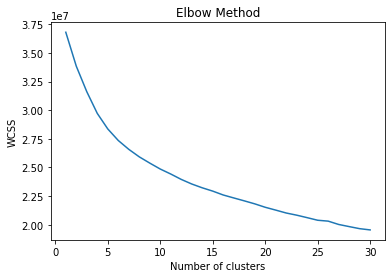

In [21]:
# Finding optimal k (elbow curve)

wcss = []

for i in tqdm(range(1, 31)):
  kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
  kmeans.fit(df_pca)

  wcss.append(kmeans.inertia_)
  
plt.plot(range(1, 31), wcss)

plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [22]:
kmeans = KMeans(n_clusters = 20, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
pred_y = kmeans.fit_predict(df_pca)

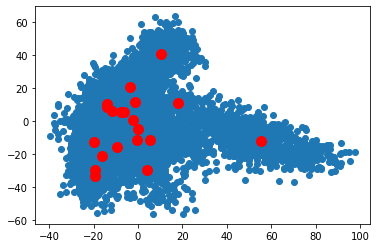

In [23]:
plt.scatter(df_pca[:,0], df_pca[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'red')
plt.show()

In [25]:
filenames_s = pd.Series(filenames)
cluster_labels_s = pd.Series(kmeans.labels_)

cluster_df = pd.concat([filenames_s, cluster_labels_s], axis = 1)
cluster_df.columns = ['filename', 'cluster']
cluster_df.head()

,filename,cluster
0,BACKGROUND_Google/image_0001.jpg,15
1,BACKGROUND_Google/image_0002.jpg,7
2,BACKGROUND_Google/image_0003.jpg,6
3,BACKGROUND_Google/image_0004.jpg,11
4,BACKGROUND_Google/image_0005.jpg,1


###  Viewing images in a cluster

In [79]:
def show_cluster_images(cluster_id, df = cluster_df):

  df = df.loc[df['cluster'] == cluster_id]
  series = df['filename']
  series = series.reset_index(drop = True)


  fig, ax = plt.subplots(nrows=1, ncols=10)
  fig.set_size_inches(15, 14)
  fig.subplots_adjust(wspace=0.1,hspace=0.1)


  for i in range(10):
    img_path = series.sample(1).item()
    full_img_path = os.path.join('101_ObjectCategories', img_path)

    image = cv2.imread(full_img_path)
    ax[i].imshow(image)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

            
  fig.tight_layout()
  fig.show()

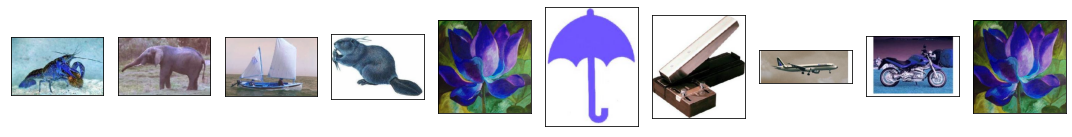

In [82]:
show_cluster_images(0)

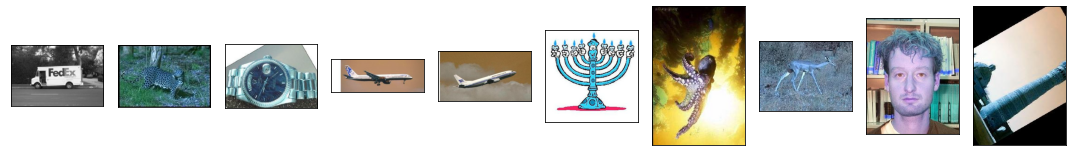

In [87]:
show_cluster_images(4)

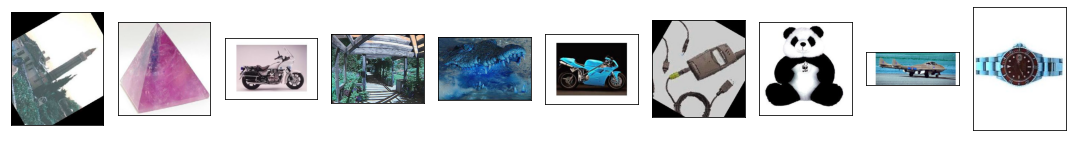

In [100]:
show_cluster_images(14)

---

## **Conclusion**

We took the model that was trained in the classification step to extract the features in this step. The features are then passed through PCA before applying k-means. `k` is chosen as 20, and some of the images of the clusters obtained are show.